In [10]:
import numpy as np
from IPython.display import clear_output
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Masking
from keras.optimizers import RMSprop, Adam
from keras.callbacks import TensorBoard, Callback
from keras import backend as k
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
"""
    Discrete log-likelihood for Weibull hazard function on censored survival data
    y_true is a (samples, 2) tensor containing time-to-event (y), and an event indicator (u)
    ab_pred is a (samples, 2) tensor containing predicted Weibull alpha (a) and beta (b) parameters
    For math, see https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
"""
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)


"""
    Custom Keras activation function, outputs alpha neuron using exponentiation and beta using softplus
"""
def activate(ab):
    print("ab:")
    print(ab)
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)


"""
    Load and parse series data files into:
       - an (series, observed history, 1) x tensor, where observed history is 100 days, zero-padded
         for days that don't have a full 100 days of observed history (e.g., first observed day for a series)
       - an (series, 2) tensor containing time-to-event and 1 (all callibrations done)
"""
def load_file(name):
    with open(name, 'r') as file:
        return np.loadtxt(file, delimiter=',')


class TrainingPlot(Callback):
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.val_losses = []
        self.mean_squared_error = []
        self.val_mean_squared_error = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        print(logs)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.mean_squared_error.append(logs.get('mean_squared_error'))
        self.val_mean_squared_error.append(logs.get('val_mean_squared_error'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            plt.rcParams['figure.figsize'] = [15, 5]
            plt.figure()
            plt.plot(N, self.mean_squared_error, label = "train_mse")
            plt.plot(N, self.val_mean_squared_error, label = "val_mse")
            
            plt.title("Training MSE [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("MSE")
            plt.legend()
            plt.show()
            
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.title("Training Loss [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
            
            

plot_losses = TrainingPlot()

np.set_printoptions(suppress=True, threshold=10000)

# Configurable observation look-back period for each series
max_time = 100

In [12]:
# Prepare data
data_x = load_file('D:/Praca Magisterska/nowe/stddevs/train_x.csv')
data_y = load_file('D:/Praca Magisterska/nowe/stddevs/train_y.csv')

number_of_module = 42
number_of_sensors = 84

# y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
data_u = np.zeros((data_y.shape[0], 1), dtype=np.float32)
data_u += 1
data_y = np.append(np.reshape(data_y, (data_y.shape[0], 1)), data_u, axis=1)

# Configurable observation look-back period for each series
max_time = 100

# A full history of sensor readings to date for each x
out_x = np.empty((0, max_time, 85), dtype=np.float32)

# Prepare particular entry as 2 features (stddev and deltatime from previous measurment), each with <max_time> length history
for i in range(data_x.shape[0]):
    this_x = np.zeros((1, max_time, 85))
    for b in range(max_time):
        if i-max_time+b+1 < 0:
            this_x[0, b, 0] = 0
        elif data_x[i-max_time+b+1, 0] < data_x[i, 0]:
            this_x[0, b, 0] = 0
        else:
            this_x[0, b, 0] = data_x[i-max_time+b+1, 5]
            
        for sensor_number in range(1,number_of_sensors+1):
            if i-max_time+b+1 < 0:
                this_x[0, b, sensor_number] = 0
            elif data_x[i-max_time+b+1, 0] < data_x[i, 0]:
                this_x[0, b, sensor_number] = 0
            else:
                this_x[0, b, sensor_number] = data_x[i-max_time+b+1, sensor_number+47]
            

    out_x = np.concatenate((out_x, this_x))

# Split data to train/test
X_train, X_test, y_train, y_test = train_test_split(out_x, data_y, test_size=0.3, shuffle=False)


In [13]:
# Start building model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=0., input_shape=(max_time, 85)))

# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
model.add(LSTM(30, input_shape=(None, 85)))

# Apply the custom activation function mentioned above
model.add(Activation('tanh'))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

# Apply the custom activation function mentioned above
model.add(Activation(activate))


ab:
Tensor("dense_2/BiasAdd:0", shape=(?, 2), dtype=float32)


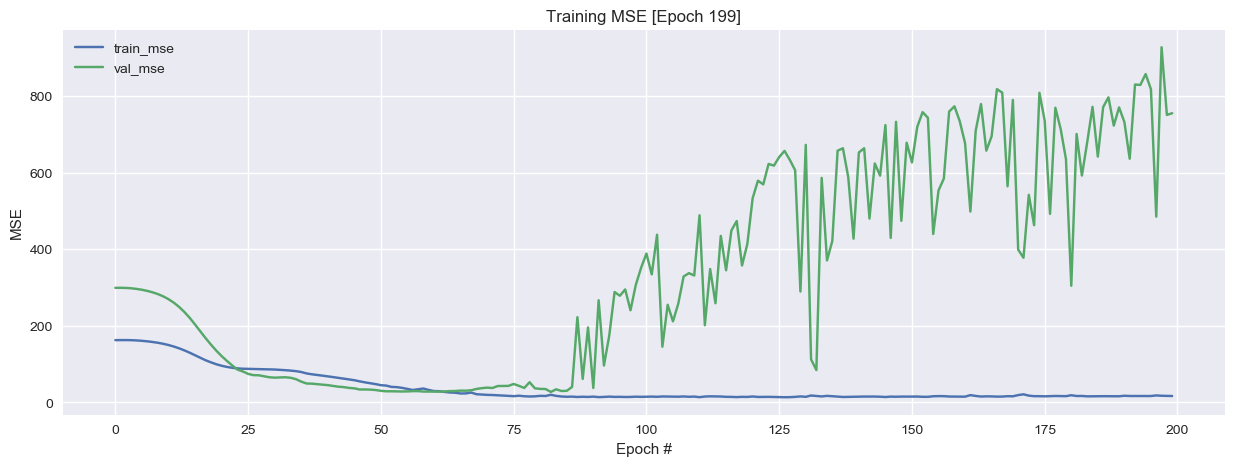

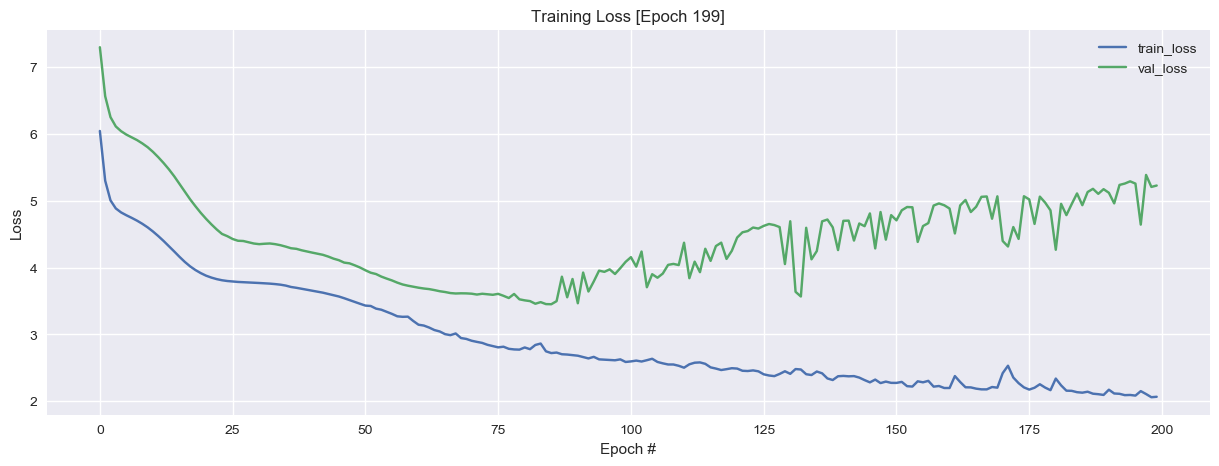

In [14]:
# Use the discrete log-likelihood for Weibull survival data as our loss function
model.compile(loss=weibull_loglik_discrete, optimizer=Adam(lr=0.0001), metrics=['mse'])
print(model.summary())

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Fit!
model.fit(X_train, y_train, epochs=200, batch_size=50, verbose=2, validation_data=(X_test, y_test), callbacks=[plot_losses], shuffle=True)

plt.style.use("default")

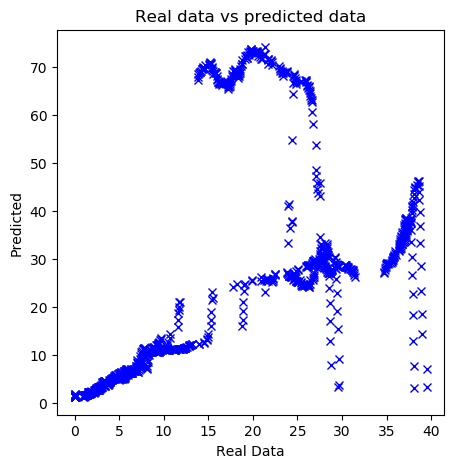

In [15]:
# Make some predictions
test_predict = model.predict(out_x)
test_predict = np.resize(test_predict, (data_y.shape[0], 2))
test_result = np.concatenate((data_y, test_predict))

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(data_y[:, 0], test_predict[:, 0], 'bx')

plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.show()

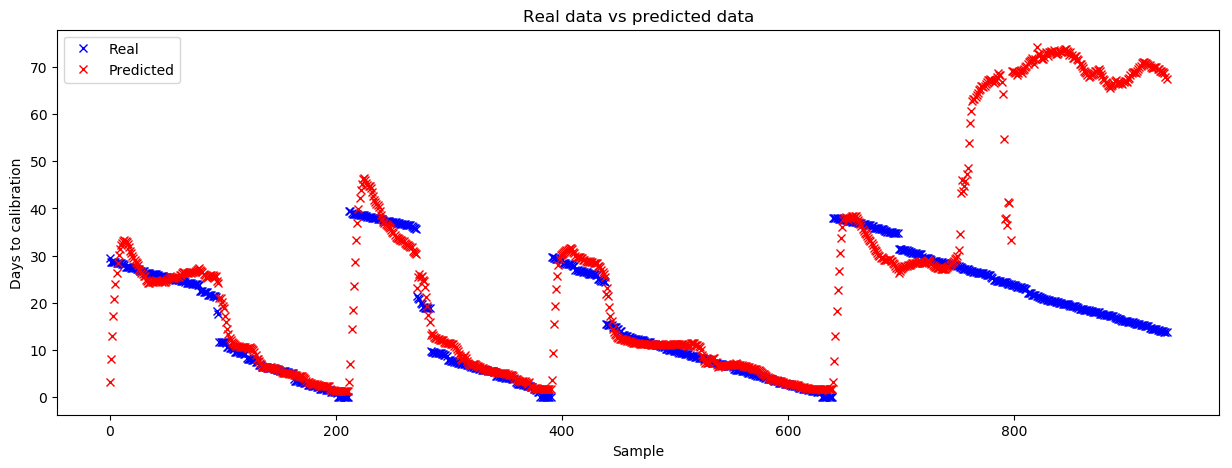

In [16]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(data_y[:, 0], 'bx', label='Real')
ax.plot(test_predict[:, 0], 'rx', label='Predicted')


plt.xlabel("Sample")
plt.ylabel("Days to calibration")
ax.legend()
plt.show()

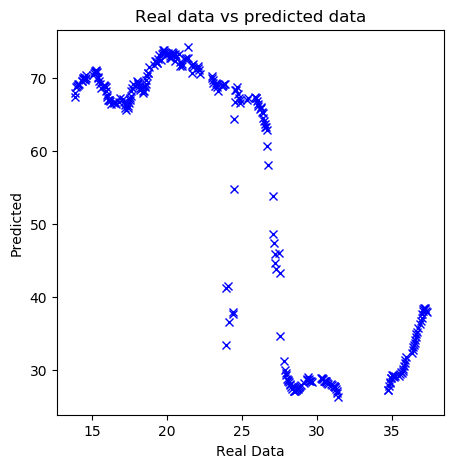

In [17]:
# Make some predictions
test_predict = model.predict(X_test)
test_predict = np.resize(test_predict, (y_test.shape[0], 2))
test_result = np.concatenate((y_test, test_predict))

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(y_test[:, 0], test_predict[:, 0], 'bx')

plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.show()

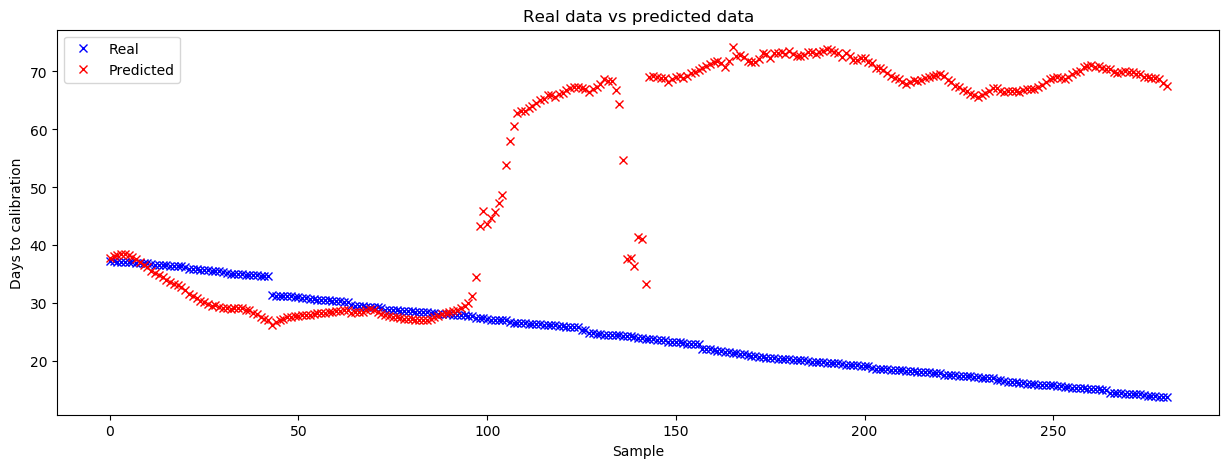

In [18]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.set_title('Real data vs predicted data')
ax.plot(y_test[:, 0], 'bx', label='Real')
ax.plot(test_predict[:, 0], 'rx', label='Predicted')


plt.xlabel("Sample")
plt.ylabel("Days to calibration")
ax.legend()
plt.show()